In [3]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [5]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y = np.tanh(y)
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, ys_L = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y = np.tanh(y)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
        if train:
            caches.append(fc_caches) # caches[1]
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches, ys):
        grads, ys_prev = self.grads, self.ys_prev # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy *= ys[1][layer] - ys_prev[1][layer] # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache = caches[0]
        dy *= ys[0] - ys_prev[0] # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            ys, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(ys[2], y_mini)
            _, grads = self.train_backward(dy, caches, ys) # ys[0], ys[1] and ys_prev are used for backprop
            self.ys_prev = ys # for next iteration or epoch learning dW and db
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [6]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100 train loss: 2.3390 valid loss: 2.3261, valid accuracy: 0.0822
Iter-200 train loss: 2.3115 valid loss: 2.3247, valid accuracy: 0.0848
Iter-300 train loss: 2.3029 valid loss: 2.3233, valid accuracy: 0.0860
Iter-400 train loss: 2.3123 valid loss: 2.3220, valid accuracy: 0.0860
Iter-500 train loss: 2.3120 valid loss: 2.3206, valid accuracy: 0.0890
Iter-600 train loss: 2.3063 valid loss: 2.3192, valid accuracy: 0.0898
Iter-700 train loss: 2.3385 valid loss: 2.3179, valid accuracy: 0.0906
Iter-800 train loss: 2.2998 valid loss: 2.3166, valid accuracy: 0.0920
Iter-900 train loss: 2.3183 valid loss: 2.3152, valid accuracy: 0.0940
Iter-1000 train loss: 2.3129 valid loss: 2.3139, valid accuracy: 0.0960
Iter-1100 train loss: 2.3401 valid loss: 2.3125, valid accuracy: 0.0978
Iter-1200 train loss: 2.3081 valid loss: 2.3112, valid accuracy: 0.1002
Iter-1300 train loss: 2.3136 valid loss: 2.3098, valid accuracy: 0.1012
Iter-1400 train loss: 2.3020 valid loss: 2.3085, valid accuracy: 0.1026
I

Iter-11500 train loss: 2.1842 valid loss: 2.1865, valid accuracy: 0.3556
Iter-11600 train loss: 2.1905 valid loss: 2.1854, valid accuracy: 0.3568
Iter-11700 train loss: 2.1845 valid loss: 2.1843, valid accuracy: 0.3574
Iter-11800 train loss: 2.2014 valid loss: 2.1832, valid accuracy: 0.3596
Iter-11900 train loss: 2.1917 valid loss: 2.1822, valid accuracy: 0.3600
Iter-12000 train loss: 2.1782 valid loss: 2.1811, valid accuracy: 0.3610
Iter-12100 train loss: 2.1583 valid loss: 2.1800, valid accuracy: 0.3618
Iter-12200 train loss: 2.2089 valid loss: 2.1789, valid accuracy: 0.3618
Iter-12300 train loss: 2.1592 valid loss: 2.1778, valid accuracy: 0.3628
Iter-12400 train loss: 2.2015 valid loss: 2.1767, valid accuracy: 0.3638
Iter-12500 train loss: 2.1420 valid loss: 2.1757, valid accuracy: 0.3642
Iter-12600 train loss: 2.1810 valid loss: 2.1745, valid accuracy: 0.3654
Iter-12700 train loss: 2.2232 valid loss: 2.1735, valid accuracy: 0.3668
Iter-12800 train loss: 2.2077 valid loss: 2.1724, v

Iter-22800 train loss: 2.1386 valid loss: 2.0732, valid accuracy: 0.4340
Iter-22900 train loss: 2.0572 valid loss: 2.0722, valid accuracy: 0.4338
Iter-23000 train loss: 2.0463 valid loss: 2.0713, valid accuracy: 0.4338
Iter-23100 train loss: 2.0540 valid loss: 2.0704, valid accuracy: 0.4340
Iter-23200 train loss: 2.0402 valid loss: 2.0695, valid accuracy: 0.4340
Iter-23300 train loss: 2.1311 valid loss: 2.0685, valid accuracy: 0.4344
Iter-23400 train loss: 2.0538 valid loss: 2.0676, valid accuracy: 0.4352
Iter-23500 train loss: 2.0961 valid loss: 2.0667, valid accuracy: 0.4350
Iter-23600 train loss: 2.0675 valid loss: 2.0658, valid accuracy: 0.4354
Iter-23700 train loss: 2.0720 valid loss: 2.0649, valid accuracy: 0.4360
Iter-23800 train loss: 2.0682 valid loss: 2.0640, valid accuracy: 0.4354
Iter-23900 train loss: 2.0509 valid loss: 2.0631, valid accuracy: 0.4362
Iter-24000 train loss: 2.0900 valid loss: 2.0622, valid accuracy: 0.4370
Iter-24100 train loss: 2.0466 valid loss: 2.0613, v

Iter-34100 train loss: 2.0080 valid loss: 1.9767, valid accuracy: 0.4742
Iter-34200 train loss: 1.9638 valid loss: 1.9759, valid accuracy: 0.4746
Iter-34300 train loss: 1.9618 valid loss: 1.9751, valid accuracy: 0.4744
Iter-34400 train loss: 2.0501 valid loss: 1.9743, valid accuracy: 0.4748
Iter-34500 train loss: 1.8634 valid loss: 1.9735, valid accuracy: 0.4758
Iter-34600 train loss: 2.0218 valid loss: 1.9727, valid accuracy: 0.4756
Iter-34700 train loss: 1.8818 valid loss: 1.9719, valid accuracy: 0.4756
Iter-34800 train loss: 2.0003 valid loss: 1.9711, valid accuracy: 0.4754
Iter-34900 train loss: 1.9841 valid loss: 1.9703, valid accuracy: 0.4756
Iter-35000 train loss: 1.9650 valid loss: 1.9695, valid accuracy: 0.4760
Iter-35100 train loss: 2.0139 valid loss: 1.9688, valid accuracy: 0.4762
Iter-35200 train loss: 1.9789 valid loss: 1.9680, valid accuracy: 0.4768
Iter-35300 train loss: 1.9168 valid loss: 1.9672, valid accuracy: 0.4770
Iter-35400 train loss: 1.9648 valid loss: 1.9664, v

Iter-45400 train loss: 1.9221 valid loss: 1.8921, valid accuracy: 0.4994
Iter-45500 train loss: 1.9022 valid loss: 1.8914, valid accuracy: 0.4998
Iter-45600 train loss: 1.8864 valid loss: 1.8908, valid accuracy: 0.5002
Iter-45700 train loss: 1.8939 valid loss: 1.8900, valid accuracy: 0.5008
Iter-45800 train loss: 1.9228 valid loss: 1.8893, valid accuracy: 0.5008
Iter-45900 train loss: 1.8643 valid loss: 1.8886, valid accuracy: 0.5010
Iter-46000 train loss: 1.8932 valid loss: 1.8879, valid accuracy: 0.5010
Iter-46100 train loss: 1.9249 valid loss: 1.8872, valid accuracy: 0.5010
Iter-46200 train loss: 1.9112 valid loss: 1.8865, valid accuracy: 0.5008
Iter-46300 train loss: 1.9050 valid loss: 1.8858, valid accuracy: 0.5014
Iter-46400 train loss: 1.9266 valid loss: 1.8851, valid accuracy: 0.5018
Iter-46500 train loss: 2.0244 valid loss: 1.8844, valid accuracy: 0.5022
Iter-46600 train loss: 1.9565 valid loss: 1.8837, valid accuracy: 0.5024
Iter-46700 train loss: 1.8720 valid loss: 1.8830, v

Iter-56700 train loss: 1.8259 valid loss: 1.8163, valid accuracy: 0.5130
Iter-56800 train loss: 1.6985 valid loss: 1.8156, valid accuracy: 0.5126
Iter-56900 train loss: 1.8382 valid loss: 1.8150, valid accuracy: 0.5134
Iter-57000 train loss: 1.7917 valid loss: 1.8144, valid accuracy: 0.5132
Iter-57100 train loss: 1.8342 valid loss: 1.8138, valid accuracy: 0.5142
Iter-57200 train loss: 1.8786 valid loss: 1.8131, valid accuracy: 0.5140
Iter-57300 train loss: 1.8374 valid loss: 1.8125, valid accuracy: 0.5148
Iter-57400 train loss: 1.7723 valid loss: 1.8118, valid accuracy: 0.5148
Iter-57500 train loss: 1.9050 valid loss: 1.8112, valid accuracy: 0.5152
Iter-57600 train loss: 1.8699 valid loss: 1.8106, valid accuracy: 0.5158
Iter-57700 train loss: 1.7802 valid loss: 1.8099, valid accuracy: 0.5158
Iter-57800 train loss: 1.8211 valid loss: 1.8093, valid accuracy: 0.5172
Iter-57900 train loss: 1.7496 valid loss: 1.8087, valid accuracy: 0.5176
Iter-58000 train loss: 1.7706 valid loss: 1.8080, v

Iter-68000 train loss: 1.7301 valid loss: 1.7476, valid accuracy: 0.5290
Iter-68100 train loss: 1.7162 valid loss: 1.7470, valid accuracy: 0.5294
Iter-68200 train loss: 1.8594 valid loss: 1.7464, valid accuracy: 0.5292
Iter-68300 train loss: 1.7353 valid loss: 1.7458, valid accuracy: 0.5294
Iter-68400 train loss: 1.7444 valid loss: 1.7452, valid accuracy: 0.5286
Iter-68500 train loss: 1.6184 valid loss: 1.7447, valid accuracy: 0.5284
Iter-68600 train loss: 1.9659 valid loss: 1.7441, valid accuracy: 0.5284
Iter-68700 train loss: 1.9950 valid loss: 1.7434, valid accuracy: 0.5292
Iter-68800 train loss: 1.7950 valid loss: 1.7429, valid accuracy: 0.5288
Iter-68900 train loss: 1.6963 valid loss: 1.7423, valid accuracy: 0.5288
Iter-69000 train loss: 1.6925 valid loss: 1.7417, valid accuracy: 0.5292
Iter-69100 train loss: 1.7196 valid loss: 1.7411, valid accuracy: 0.5296
Iter-69200 train loss: 1.7823 valid loss: 1.7405, valid accuracy: 0.5294
Iter-69300 train loss: 1.6013 valid loss: 1.7400, v

Iter-79300 train loss: 1.6351 valid loss: 1.6847, valid accuracy: 0.5394
Iter-79400 train loss: 1.6662 valid loss: 1.6842, valid accuracy: 0.5396
Iter-79500 train loss: 1.6797 valid loss: 1.6836, valid accuracy: 0.5390
Iter-79600 train loss: 1.5986 valid loss: 1.6831, valid accuracy: 0.5396
Iter-79700 train loss: 1.6612 valid loss: 1.6826, valid accuracy: 0.5398
Iter-79800 train loss: 1.7280 valid loss: 1.6821, valid accuracy: 0.5396
Iter-79900 train loss: 1.6789 valid loss: 1.6816, valid accuracy: 0.5396
Iter-80000 train loss: 1.7156 valid loss: 1.6811, valid accuracy: 0.5402
Iter-80100 train loss: 1.6420 valid loss: 1.6806, valid accuracy: 0.5400
Iter-80200 train loss: 1.5138 valid loss: 1.6801, valid accuracy: 0.5400
Iter-80300 train loss: 1.7009 valid loss: 1.6795, valid accuracy: 0.5408
Iter-80400 train loss: 1.6541 valid loss: 1.6790, valid accuracy: 0.5408
Iter-80500 train loss: 1.7597 valid loss: 1.6784, valid accuracy: 0.5408
Iter-80600 train loss: 1.7574 valid loss: 1.6779, v

Iter-90600 train loss: 1.5047 valid loss: 1.6271, valid accuracy: 0.5466
Iter-90700 train loss: 1.6197 valid loss: 1.6265, valid accuracy: 0.5462
Iter-90800 train loss: 1.6976 valid loss: 1.6261, valid accuracy: 0.5460
Iter-90900 train loss: 1.6290 valid loss: 1.6256, valid accuracy: 0.5464
Iter-91000 train loss: 1.7106 valid loss: 1.6251, valid accuracy: 0.5466
Iter-91100 train loss: 1.4722 valid loss: 1.6246, valid accuracy: 0.5468
Iter-91200 train loss: 1.6737 valid loss: 1.6241, valid accuracy: 0.5466
Iter-91300 train loss: 1.6617 valid loss: 1.6236, valid accuracy: 0.5468
Iter-91400 train loss: 1.6113 valid loss: 1.6232, valid accuracy: 0.5476
Iter-91500 train loss: 1.6325 valid loss: 1.6227, valid accuracy: 0.5474
Iter-91600 train loss: 1.7192 valid loss: 1.6222, valid accuracy: 0.5476
Iter-91700 train loss: 1.6256 valid loss: 1.6218, valid accuracy: 0.5474
Iter-91800 train loss: 1.6559 valid loss: 1.6213, valid accuracy: 0.5472
Iter-91900 train loss: 1.6291 valid loss: 1.6207, v

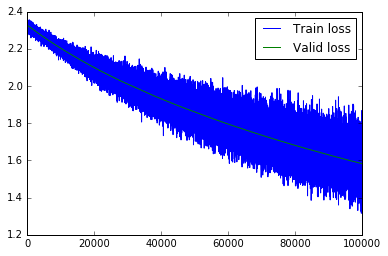

In [7]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

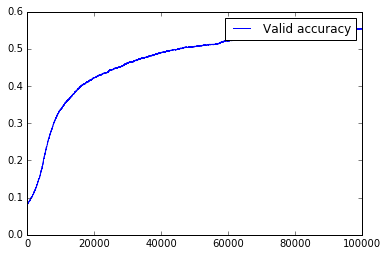

In [8]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()